In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from cmcrameri import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle 
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# open the glacier-specific future ela changes
# path_dela = os.path.join(folder_climate, 'CMIP', "rgi_delta_ELA.csv")
# dela_df = pd.read_csv(path_dela)

# # open glacier-specific AAR changes
# path_daar = os.path.join(folder_save, 'Average AAs', 'CMIP_derived_AARs.csv')

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))
# all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, dela_df, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
# add columns for percent AA lost at 100, 200m
all_data_gdf['aa_lost_100'] = (all_data_gdf['hyps_aar']-all_data_gdf['hyps_aar_100'])*100/all_data_gdf['hyps_aar']
all_data_gdf['aa_lost_200'] = (all_data_gdf['hyps_aar']-all_data_gdf['hyps_aar_200'])*100/all_data_gdf['hyps_aar']
all_data_gdf['aa_lost_cmip'] = (all_data_gdf['hyps_aar']-all_data_gdf['hyps_aar_cmip'])*100/all_data_gdf['hyps_aar']

In [5]:
# for glaciers that already have 0 hypsometric aa, we want the aa_lost to be 100, rather than 0
all_data_gdf.loc[all_data_gdf['off_glacier_avg_product']==1, 'aa_lost_cmip'] = 100

# full_data_df.loc[full_data_df[f'off_glacier_{y}'].astype(str)=="True", f'ela_{y}'] = full_data_df.loc[full_data_df[f'off_glacier_{y}'].astype(str)=="True", 'Zmax']

In [6]:
all_data_gdf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,hyps_aar_440,hyps_aar_460,hyps_aar_480,hyps_aar_500,hyps_aar_cmip,delta_ela_cmip,geometry,aa_lost_100,aa_lost_200,aa_lost_cmip
0,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.120000,63.381000,1,2,3.681,1273,...,0.0004,0.0000,0.0000,0.0000,0.4362,101,"POLYGON ((390852.892 1513270.533, 390859.011 1...",29.754847,67.793623,30.107355
1,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.057000,63.551000,1,2,2.573,1494,...,0.0000,0.0000,0.0000,0.0000,0.0495,112,"POLYGON ((344516.095 1527311.059, 344445.809 1...",80.712858,97.668221,83.510993
2,RGI60-01.00006,G213756E63571N,20090703,-9999999,-146.244000,63.571000,1,2,10.470,1201,...,0.1754,0.1687,0.1620,0.1536,0.3342,101,"POLYGON ((383858.051 1532357.663, 383852.553 1...",10.045662,25.973677,10.233683
3,RGI60-01.00010,G212830E63513N,20090703,-9999999,-147.170000,63.513000,1,2,3.806,1280,...,0.0000,0.0000,0.0000,0.0000,0.0000,112,"POLYGON ((339736.019 1522275.072, 339760.103 1...",100.000000,100.000000,100.000000
4,RGI60-01.00012,G213349E63366N,20090703,-9999999,-146.651000,63.366000,1,2,2.802,1318,...,0.0000,0.0000,0.0000,0.0000,0.0233,101,"POLYGON ((367276.652 1509860.919, 367276.151 1...",87.320955,100.000000,87.639257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,RGI60-01.27103,G225914E58943N,20050811,-9999999,-134.086000,58.943000,1,6,86.656,873,...,0.0035,0.0025,0.0015,0.0007,0.0995,214,"POLYGON ((1124430.012 1178580.750, 1124448.074...",29.479216,81.764612,84.153528
2998,RGI60-01.27105,G227608E57164N,20040810,-9999999,-132.392000,57.164000,1,6,131.574,507,...,0.0462,0.0417,0.0351,0.0285,0.0909,249,"POLYGON ((1288393.613 1007526.726, 1288472.876...",21.796276,42.661555,50.219058
2999,RGI60-01.27106,G220930E60344N,20100814,-9999999,-139.070000,60.344000,1,5,2.758,3481,...,0.1031,0.0875,0.0713,0.0569,0.8489,99,"POLYGON ((814691.319 1241084.011, 814644.576 1...",14.950734,47.848381,14.649105
3000,RGI60-01.27108,G216273E60232N,20100910,-9999999,-143.726807,60.231728,1,5,534.228,3,...,0.0275,0.0265,0.0255,0.0245,0.0531,139,"POLYGON ((604319.534 1222790.506, 604320.481 1...",19.502075,36.929461,26.556017


In [7]:
### get the hypsometric analysis stats
# find hypsometric aar
all_data_gdf["hyps_aar_0"] = all_data_gdf["hyps_aar"]
all_data_gdf['hyps_aa'] = all_data_gdf["hyps_aar"] * all_data_gdf["Area"]
all_data_gdf['hyps_0_aa'] = all_data_gdf["hyps_aar"] * all_data_gdf["Area"]
all_data_gdf['hyps_cmip_aa'] = all_data_gdf["hyps_aar_cmip"] * all_data_gdf["Area"]
for i in np.arange(0,201,20):
    all_data_gdf[f'hyps_{i}_aa'] = all_data_gdf[f"hyps_aar_{i}"] * all_data_gdf["Area"]

In [8]:
# get hypsometric aa, aar for each 03region
o3_df = pd.DataFrame(all_data_gdf.groupby('O3Region')['Area'].sum().rename('area'))
o3_df['hyps_aa'] = all_data_gdf.groupby('O3Region')[f'hyps_aa'].sum()
o3_df['hyps_aar'] = o3_df[f'hyps_aa']/o3_df['area']
for i in np.arange(0,201,20):
    o3_df[f'hyps_{i}_aa'] = all_data_gdf.groupby('O3Region')[f'hyps_{i}_aa'].sum()
    o3_df[f'hyps_{i}_aar'] = o3_df[f'hyps_{i}_aa']/o3_df['area']

o3_df[f'hyps_cmip_aa'] = all_data_gdf.groupby('O3Region')[f'hyps_cmip_aa'].sum()
o3_df[f'hyps_cmip_aar'] = o3_df[f'hyps_cmip_aa']/o3_df['area']

# remove the glaciers in O3Region=0 (these are glaciers that don't fit into any of the regions)
o3_df = o3_df.drop(0, axis=0).reset_index()
o3_df

,O3Region,area,hyps_aa,hyps_aar,hyps_0_aa,hyps_0_aar,hyps_20_aa,hyps_20_aar,hyps_40_aa,hyps_40_aar,...,hyps_140_aa,hyps_140_aar,hyps_160_aa,hyps_160_aar,hyps_180_aa,hyps_180_aar,hyps_200_aa,hyps_200_aar,hyps_cmip_aa,hyps_cmip_aar
0,1,1554.897,401.409213,0.258158,401.409213,0.258158,373.963046,0.240507,345.948465,0.222490,...,227.430430,0.146267,207.890956,0.133701,189.616617,0.121948,172.177359,0.110732,216.694149,0.139362
1,2,2359.375,772.350256,0.327354,772.350256,0.327354,717.819850,0.304242,663.957495,0.281412,...,425.110355,0.180179,386.068266,0.163632,347.363762,0.147227,312.448790,0.132429,341.110372,0.144577
2,3,1710.748,562.988723,0.329089,562.988723,0.329089,537.277526,0.314060,513.640847,0.300243,...,413.094880,0.241470,397.573616,0.232398,383.374426,0.224098,369.855014,0.216195,392.971982,0.229708
3,4,3275.767,1109.679451,0.338754,1109.679451,0.338754,1072.442469,0.327387,1036.261257,0.316342,...,863.317055,0.263547,832.076750,0.254010,803.728830,0.245356,776.408887,0.237016,869.392065,0.265401
4,5,2323.194,793.248187,0.341447,793.248187,0.341447,750.815426,0.323182,708.602887,0.305012,...,520.936380,0.224233,487.877056,0.210003,455.845659,0.196215,424.556760,0.182747,589.113213,0.253579
5,6,4323.462,2190.193891,0.506583,2190.193891,0.506583,2131.690126,0.493052,2070.373755,0.478869,...,1767.277246,0.408764,1705.716673,0.394526,1648.257591,0.381236,1591.786431,0.368174,1772.096033,0.409879
6,7,263.569,108.041049,0.409916,108.041049,0.409916,98.623337,0.374184,89.034876,0.337805,...,47.731422,0.181096,41.500997,0.157458,35.680775,0.135375,30.003710,0.113836,54.117130,0.205324
7,8,2139.982,1018.717141,0.476040,1018.717141,0.476040,965.225937,0.451044,905.478944,0.423125,...,632.007901,0.295333,580.491045,0.271260,536.574764,0.250738,492.572367,0.230176,637.159733,0.297741
8,9,1595.633,754.619832,0.472928,754.619832,0.472928,712.652365,0.446627,671.114277,0.420594,...,467.736332,0.293135,429.025810,0.268875,394.396650,0.247173,359.919219,0.225565,483.380066,0.302939
9,10,6750.535,2747.393138,0.406989,2747.393138,0.406989,2636.018750,0.390490,2527.824937,0.374463,...,2045.609066,0.303029,1960.521710,0.290425,1879.758793,0.278461,1804.823861,0.267360,2062.664255,0.305556


In [9]:
# get hypsometric aa, aar for each 02region
o2_df = pd.DataFrame(all_data_gdf.groupby('O2Region')['Area'].sum().rename('area'))
o2_df['Name'] = ["Alaska Range", "Alaska Peninsula", "West Chugach Mountains", "Saint Elias Mountains", "North Coast Ranges"]
o2_df['hyps_aa'] = all_data_gdf.groupby('O2Region')[f'hyps_aa'].sum()
o2_df['hyps_aar'] = o2_df[f'hyps_aa']/o2_df['area']
for i in np.arange(0,201,20):
    o2_df[f'hyps_{i}_aa'] = all_data_gdf.groupby('O2Region')[f'hyps_{i}_aa'].sum()
    o2_df[f'hyps_{i}_aar'] = o2_df[f'hyps_{i}_aa']/o2_df['area']

o2_df[f'hyps_cmip_aa'] = all_data_gdf.groupby('O2Region')[f'hyps_cmip_aa'].sum()
o2_df[f'hyps_cmip_aar'] = o2_df[f'hyps_cmip_aa']/o2_df['area']

o2_df

,area,Name,hyps_aa,hyps_aar,hyps_0_aa,hyps_0_aar,hyps_20_aa,hyps_20_aar,hyps_40_aa,hyps_40_aar,...,hyps_140_aa,hyps_140_aar,hyps_160_aa,hyps_160_aar,hyps_180_aa,hyps_180_aar,hyps_200_aa,hyps_200_aar,hyps_cmip_aa,hyps_cmip_aar
O2Region,,,,,,,,,,,,,,,,,,,,,
2,14001.540,Alaska Range,5428.460508,0.387705,5428.460508,0.387705,5210.045397,0.372105,4992.836240,0.356592,...,3989.735915,0.284950,3809.312361,0.272064,3638.570268,0.259869,3475.055883,0.248191,3964.683665,0.283161
3,1554.897,Alaska Peninsula,401.409213,0.258158,401.409213,0.258158,373.963046,0.240507,345.948465,0.222490,...,227.430430,0.146267,207.890956,0.133701,189.616617,0.121948,172.177359,0.110732,216.694149,0.139362
4,10749.719,West Chugach Mountains,4628.771161,0.430595,4628.771161,0.430595,4412.520389,0.410478,4193.453033,0.390099,...,3193.084721,0.297039,3011.539562,0.280151,2846.410983,0.264789,2687.319156,0.249990,3237.321184,0.301154
5,31321.245,Saint Elias Mountains,14927.870481,0.476605,14927.870481,0.476605,14599.646113,0.466126,14248.947154,0.454929,...,12549.101952,0.400658,12212.459552,0.389910,11864.797449,0.378810,11527.855096,0.368052,13083.340105,0.417715
6,18663.934,North Coast Ranges,8134.849192,0.435859,8134.849192,0.435859,7763.437786,0.415959,7387.625752,0.395824,...,5552.819722,0.297516,5216.073511,0.279473,4897.463297,0.262403,4597.210391,0.246315,4426.617928,0.237175


In [10]:
# define a 16-color categorical color palette
# http://vrl.cs.brown.edu/color
from matplotlib.colors import ListedColormap
# hex_codes = ["#a0e3b7", "#b33c85", "#37b51f", "#b32df9", "#7e9b3d", "#333dcd", "#c0e15c", "#fe7dda", "#235e31", "#be0332", "#20d8fd", "#6c3640", "#21f0b6", "#ec7f6a", "#0362a0", "#f79302"]
# hex_codes = ["#3c2d80", "#609111", "#e30293", "#20502e", "#ec102f", "#219571", "#ce5d8e", "#3d8bb7", "#b94403", "#a143f9", "#604020", "#577cf5", "#ae783e", "#4b03a9", "#9679a6", "#154975"]
hex_codes = ["#097969","#FF3131","#CC5500","#D2042D","#880808","#EC5800","#1434A4","#3d8bb7","#0000FF","#577cf5","#FFD700","#C4B454","#DA70D6","#702963","#9679a6","#9F2B68"]
cmap_16 = ListedColormap(hex_codes)

# create list of o3region numbers, names, hex codes
numbers = np.arange(1,17)
names = [ all_data_gdf[all_data_gdf['O3Region']==n]['O3_name'].values[0] for n in numbers]
colors = [ hex_codes[n-1] for n in numbers ]
names[11] = 'St Elias Mountains'

o3_info_df = pd.DataFrame({'Number':numbers, 'Name':names, 'Color':colors})
o3_info_df

,Number,Name,Color
0,1,Aleutian Range,#097969
1,2,Northern Aleutian Range,#FF3131
2,3,Western Alaska Range,#CC5500
3,4,Central Alaska Range,#D2042D
4,5,Eastern Alaska Range,#880808
5,6,Wrangell Mountains,#EC5800
6,7,Talkeetna Mountains,#1434A4
7,8,Southern Kenai Mountains,#3d8bb7
8,9,Northern Kenai Mountains,#0000FF
9,10,Western Chugach Mountains,#577cf5


In [11]:
# define a 5-color categorical color palette
# https://carbondesignsystem.com/data-visualization/color-palettes/
from matplotlib.colors import ListedColormap
hex_codes = ["#E69F00", "#760079", "#009E73", "#0072B2", "#C30018"]

cmap_5 = ListedColormap(hex_codes)

# create list of o3region numbers, names, hex codes
numbers = np.arange(2,7)
names = ["Alaska Range", "Alaska Peninsula", "West Chugach Mountains", "Saint Elias Mountains", "North Coast Ranges"]
colors = [ hex_codes[n-2] for n in numbers ]
# names[11] = 'St Elias Mountains'

o2_info_df = pd.DataFrame({'Number':numbers, 'Name':names, 'Color':colors})
# o2_info_df = pd.DataFrame({'Number':numbers, 'Color':colors})
o2_info_df

,Number,Name,Color
0,2,Alaska Range,#E69F00
1,3,Alaska Peninsula,#760079
2,4,West Chugach Mountains,#009E73
3,5,Saint Elias Mountains,#0072B2
4,6,North Coast Ranges,#C30018


In [12]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [13]:
# # start figure
# fig,axs = snowFun.create_three_base_maps(hillshade=0, width=6.5, height=3.25, closeup=True)
# ax0, ax1, ax2, axp = (axs[0,1], axs[1,0], axs[1,1], axs[0,0])

# # cmap_pad = -0.2
# # cmap_fraction = 0.03

# # create inset cbar axes
# cloc = (0.3,0.15,0.3,0.07)
# cb_ax0 = ax0.inset_axes( cloc, transform=ax0.transAxes)
# cb_ax1 = ax1.inset_axes( cloc, transform=ax1.transAxes)
# cb_ax2 = ax2.inset_axes( cloc, transform=ax2.transAxes)

# # add data to maps
# im = all_data_gdf.plot(ax=ax0, column='delta_ela_cmip', zorder=10, cmap=cm.bilbao_r, vmin=50, vmax=250, legend=True,
#                           legend_kwds={'cax':cb_ax0, 'ticks':None, 'orientation':'horizontal'})

# im = all_data_gdf.plot(ax=ax1, column='hyps_aar_cmip', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
#                           legend_kwds={'cax':cb_ax1, 'ticks':None, 'orientation':'horizontal', 'extend':None})

# im = all_data_gdf.plot(ax=ax2, column='aa_lost_cmip', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
#                           legend_kwds={'cax':cb_ax2, 'ticks':[0,25,50,75], 'orientation':'horizontal',
#                                        'extend':'max', "extendfrac":0.1})


# # # format colorbars
# labels = ['ELA Rise (m)', 'AAR', 'AA Lost (%)']
# for i,ax in enumerate([cb_ax0,cb_ax1,cb_ax2]):
#     ax.tick_params(labelsize=5, length=2, pad=1)
#     ax.set_xlabel(labels[i], size=5, labelpad=1.5) 
#     ax.xaxis.set_label_position('top')

# # format titles on each plot
# labels = ['a.', 'b. Expected ELA Rise (m)', 'c. Future AAR', 'd. Accumulation Area Lost (%)']
# for i,ax in enumerate([axp, ax0, ax1, ax2]):
#     ax.set_title("")
    
#     if i!=0:
#         ax.text(0.01, 0.93, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)
#     else:
#         ax.text(0.05, 0.93, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)
    
# ### plot timeseries in other axis

# # final touches
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)

# # save
# out_path = os.path.join(folder_AGVA, 'Figures', 'future aars', 'future_aars_cmip.png')
# # plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

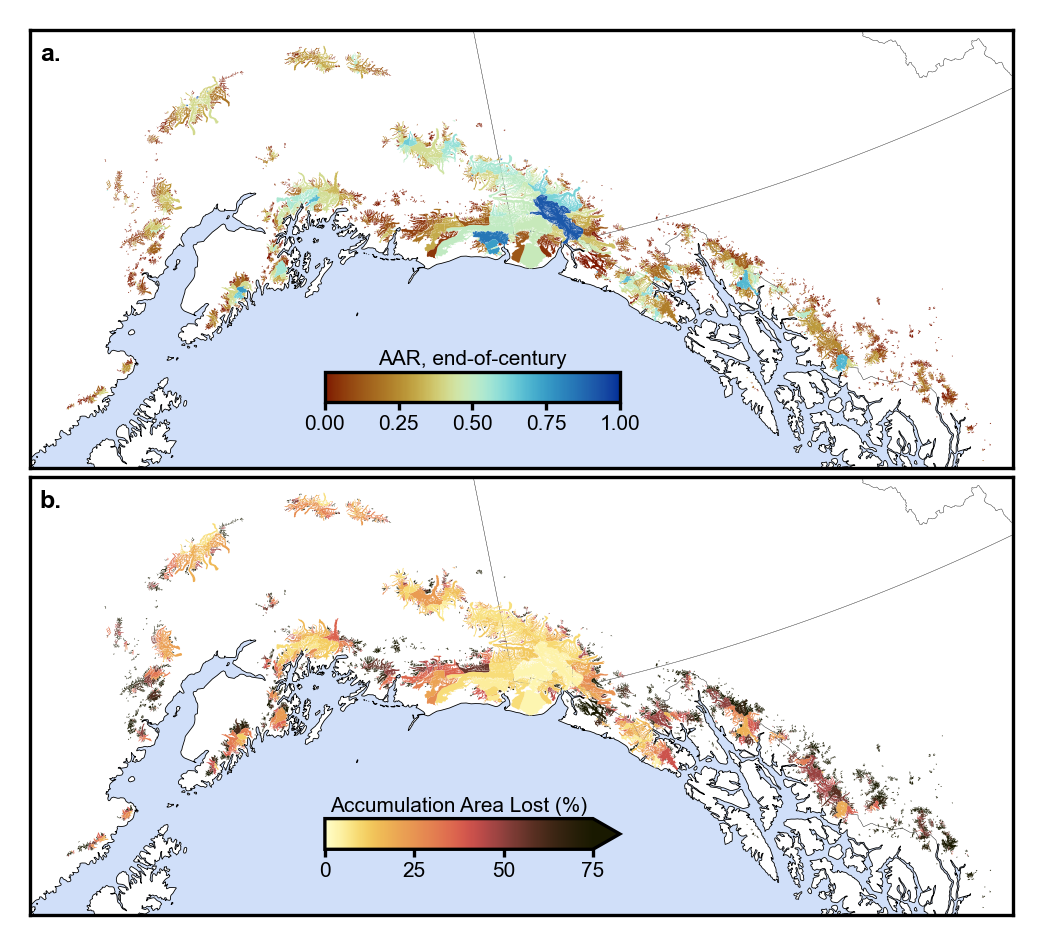

In [14]:
# start figure
fig,axs = snowFun.create_two_base_maps(hillshade=0, width=6.5, height=3.25, closeup=True, orient='v')
ax1, ax2= (axs[0], axs[1])

# cmap_pad = -0.2
# cmap_fraction = 0.03

# create inset cbar axes
cloc = (0.3,0.15,0.3,0.07)
cb_ax1 = ax1.inset_axes( cloc, transform=ax1.transAxes)
cb_ax2 = ax2.inset_axes( cloc, transform=ax2.transAxes)

# add data to maps
# im = all_data_gdf.plot(ax=ax0, column='delta_ela_cmip', zorder=10, cmap=cm.bilbao_r, vmin=50, vmax=250, legend=True,
#                           legend_kwds={'cax':cb_ax0, 'ticks':None, 'orientation':'horizontal'})

im = all_data_gdf.plot(ax=ax1, column='hyps_aar_cmip', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
                          legend_kwds={'cax':cb_ax1, 'ticks':None, 'orientation':'horizontal', 'extend':None})

im = all_data_gdf.plot(ax=ax2, column='aa_lost_cmip', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
                          legend_kwds={'cax':cb_ax2, 'ticks':[0,25,50,75], 'orientation':'horizontal',
                                       'extend':'max', "extendfrac":0.1})


# # format colorbars
labels = ['AAR, end-of-century', 'Accumulation Area Lost (%)']
for i,ax in enumerate([cb_ax1,cb_ax2]):
    ax.tick_params(labelsize=5, length=2, pad=1)
    ax.set_xlabel(labels[i], size=5, labelpad=1.5) 
    ax.xaxis.set_label_position('top')

# format titles on each plot
labels = ['a.', 'b.']
for i,ax in enumerate([ax1, ax2]):
    ax.set_title("")

    ax.text(0.01, 0.93, labels[i],
        fontsize=6, weight='bold',
        transform = ax.transAxes)

    
### plot timeseries in other axis

# final touches
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.02)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'future aars', 'future_aars_cmip_v.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [15]:
# # start figure
# fig,axs = snowFun.create_three_base_maps(hillshade=0, width=6.5, height=3.25, closeup=True)
# ax0, ax1, ax2, axp = (axs[0,1], axs[1,0], axs[1,1], axs[0,0])

# # cmap_pad = -0.2
# # cmap_fraction = 0.03

# # create inset cbar axes
# cloc = (0.3,0.15,0.3,0.07)
# cb_ax0 = ax0.inset_axes( cloc, transform=ax0.transAxes)
# cb_ax1 = ax1.inset_axes( cloc, transform=ax1.transAxes)
# cb_ax2 = ax2.inset_axes( cloc, transform=ax2.transAxes)

# # add data to maps
# im = all_data_gdf.plot(ax=ax0, column='delta_ela_cmip', zorder=10, cmap=cm.bilbao_r, vmin=50, vmax=250, legend=True,
#                           legend_kwds={'cax':cb_ax0, 'ticks':None, 'orientation':'horizontal'})

# im = all_data_gdf.plot(ax=ax1, column='hyps_aar_cmip', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
#                           legend_kwds={'cax':cb_ax1, 'ticks':None, 'orientation':'horizontal', 'extend':None})

# im = all_data_gdf.plot(ax=ax2, column='aa_lost_cmip', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
#                           legend_kwds={'cax':cb_ax2, 'ticks':[0,25,50,75], 'orientation':'horizontal',
#                                        'extend':'max', "extendfrac":0.1})


# # # format colorbars
# labels = ['ELA Rise (m)', 'AAR', 'AA Lost (%)']
# for i,ax in enumerate([cb_ax0,cb_ax1,cb_ax2]):
#     ax.tick_params(labelsize=5, length=2, pad=1)
#     ax.set_xlabel(labels[i], size=5, labelpad=1.5) 
#     ax.xaxis.set_label_position('top')

# # format titles on each plot
# labels = ['a.', 'b. Expected ELA Rise (m)', 'c. Future AAR', 'd. Accumulation Area Lost (%)']
# for i,ax in enumerate([axp, ax0, ax1, ax2]):
#     ax.set_title("")
    
#     if i!=0:
#         ax.text(0.01, 0.93, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)
#     else:
#         ax.text(0.05, 0.93, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)
    
# ### plot timeseries in other axis

# # final touches
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)

# # save
# out_path = os.path.join(folder_AGVA, 'Figures', 'future aars', 'future_aars_cmip.png')
# # plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [16]:
# # start figure
# fig,axs = snowFun.create_three_base_maps(hillshade=0, width=6.5, height=3.25, closeup=True)
# ax0, ax1, ax2, axp = (axs[0,1], axs[1,0], axs[1,1], axs[0,0])

# # cmap_pad = -0.2
# # cmap_fraction = 0.03

# # create inset cbar axes
# cloc = (0.3,0.15,0.3,0.07)
# cb_ax0 = ax0.inset_axes( cloc, transform=ax0.transAxes)
# cb_ax1 = ax1.inset_axes( cloc, transform=ax1.transAxes)
# cb_ax2 = ax2.inset_axes( cloc, transform=ax2.transAxes)

# # add data to maps
# im = all_data_gdf.plot(ax=ax0, column='hyps_aar', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
#                           legend_kwds={'cax':cb_ax0, 'ticks':[0,0.25,0.5,0.75,1], 'orientation':'horizontal'})

# im = all_data_gdf.plot(ax=ax1, column='aa_lost_100', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
#                           legend_kwds={'cax':cb_ax1, 'ticks':[0,25,50,75], 'orientation':'horizontal',
#                                        'extend':'max', "extendfrac":0.1})

# im = all_data_gdf.plot(ax=ax2, column='aa_lost_200', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
#                           legend_kwds={'cax':cb_ax2, 'ticks':[0,25,50,75], 'orientation':'horizontal',
#                                        'extend':'max', "extendfrac":0.1})

# # format colorbars
# labels = ['Present Day AAR', 'Accumulation Area Lost (%)', 'Accumulation Area Lost (%)']
# for i,ax in enumerate([cb_ax0,cb_ax1,cb_ax2]):
#     ax.tick_params(labelsize=5, length=2, pad=1)
#     ax.set_xlabel(labels[i], size=5, labelpad=1.5) 
#     ax.xaxis.set_label_position('top')

# # format titles on each plot
# labels = ['a.', 'b. Present Day','c. 100 m ELA rise','d. 200 m ELA rise']
# for i,ax in enumerate([axp, ax0, ax1, ax2]):
#     ax.set_title("")
    
#     if i!=0:
#         ax.text(0.01, 0.93, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)
#     else:
#         ax.text(0.05, 0.93, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)
    
# ### plot timeseries in other axis
# cmap = mpl.colormaps['prism']
# cmap = ListedColormap(cmap(np.linspace(0, 1, 17)))
# cmap = cmap_16

# # # make separate line for each 03 subregion
# # for idx,row in o3_df.iterrows():
# #     xs = np.arange(0,201,20)
# #     ys = [row[f'hyps_{x}_aar'] for x in xs]
# #     axp.plot(xs,ys, c=cmap(idx), linestyle='solid', alpha=0.8, linewidth=0.7)
    
# # make separate line for each 02 subregion
# for idx,row in o2_df.iterrows():
#     xs = np.arange(0,201,20)
#     ys = [row[f'hyps_{x}_aar'] for x in xs]
#     axp.plot(xs,ys, c=cmap_5(idx-2), linestyle='solid', alpha=0.8, linewidth=1.2, label=row['Name'])

# # lastly, plot the entire region's AAR change
# ys = []
# for x in xs:
#     ys.append( np.nansum(all_data_gdf[f"hyps_{x}_aa"])/np.nansum(all_data_gdf["Area"]) )
# axp.plot(xs, ys, c='black', linewidth=2, linestyle=(0, (5,1)), label='Overall')

# # create legend
# l = axp.legend(ncols=3, fontsize=5, fancybox=False, handlelength=1, handletextpad=0.4,
#            framealpha=1, edgecolor='black', shadow=False, borderpad=0.4,
#            loc='lower left', bbox_to_anchor=(0.01,0.02))

# axp.set_xlim(-5,205)
# axp.set_ylim(0,0.55)
# axp.set_xlabel("ELA Rise (m)", size=6, labelpad=0)
# axp.set_ylabel("AAR", size=6, labelpad=0)
# axp.tick_params(axis='both', direction='in', labelsize=6, pad=1)
# axp.grid(zorder=1, linestyle='dashed', linewidth=0.4)

# # final touches
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)

# # save
# out_path = os.path.join(folder_AGVA, 'Figures', 'future aars', 'future_aars2_close.png')
# # plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [17]:
print(xs)
print(ys)

NameError: name 'xs' is not defined

In [ ]:
# # start figure
# fig,axs = snowFun.create_three_base_maps(hillshade=0, closeup=True)
# ax0, ax1, ax2, axp = (axs[0,1], axs[1,0], axs[1,1], axs[0,0])

# # cmap_pad = -0.2
# # cmap_fraction = 0.03

# # create inset cbar axes
# cloc = (0.35,0.15,0.3,0.07)
# cb_ax0 = ax0.inset_axes( cloc, transform=ax0.transAxes)
# cb_ax1 = ax1.inset_axes( cloc, transform=ax1.transAxes)
# cb_ax2 = ax2.inset_axes( cloc, transform=ax2.transAxes)

# # add data to maps
# im = all_data_gdf.plot(ax=ax0, column='hyps_aar', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
#                           legend_kwds={'cax':cb_ax0, 'ticks':[0,0.25,0.5,0.75,1], 'orientation':'horizontal'})

# im = all_data_gdf.plot(ax=ax1, column='aa_lost_100', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
#                           legend_kwds={'cax':cb_ax1, 'ticks':[0,25,50,75], 'orientation':'horizontal',
#                                        'extend':'max', "extendfrac":0.1})

# im = all_data_gdf.plot(ax=ax2, column='aa_lost_200', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
#                           legend_kwds={'cax':cb_ax2, 'ticks':[0,25,50,75], 'orientation':'horizontal',
#                                        'extend':'max', "extendfrac":0.1})

# # format colorbars
# labels = ['Present Day AAR', 'Accumulation Area Lost (%)', 'Accumulation Area Lost (%)']
# for i,ax in enumerate([cb_ax0,cb_ax1,cb_ax2]):
#     ax.tick_params(labelsize=5, length=2, pad=1)
#     ax.set_xlabel(labels[i], size=5, labelpad=1.5) 
#     ax.xaxis.set_label_position('top')

# # format titles on each plot
# labels = ['b. Present Day','c. 100 m ELA rise','d. 200 m ELA rise']
# for i,ax in enumerate([ax0, ax1, ax2]):
#     ax.set_title("")
#     ax.text(0.07, 0.94, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)
    
# axp.set_title("")
# axp.text(0.03, 0.90, 'a.',
#             fontsize=6, weight='bold',
#             transform = axp.transAxes)
    
# ### plot timeseries in other axis
# cmap = mpl.colormaps['prism']
# cmap = ListedColormap(cmap(np.linspace(0, 1, 17)))
# cmap = cmap_16

# # make separate line for each subregion
# for idx,row in o3_df.iterrows():
#     xs = np.arange(0,201,20)
#     ys = [row[f'hyps_{x}_aar']/row[f'hyps_0_aar'] for x in xs]
#     axp.plot(xs,ys, c=cmap(idx), linestyle='solid', alpha=0.8, linewidth=0.7)

# # lastly, plot the entire region's AAR change
# aar_today = np.nansum( (all_data_gdf[f"hyps_0_aa"]) / np.nansum(all_data_gdf["Area"]) )
# ys = []
# for x in xs:
#     aar_future = np.nansum( (all_data_gdf[f"hyps_{x}_aa"]) / np.nansum(all_data_gdf["Area"]) )
#     ys.append(aar_future/aar_today)
    
# axp.plot(xs, ys, c='black', linewidth=1.5, linestyle=(0, (5,1)))

# axp.set_xlim(-5,205)
# axp.set_ylim(0,1.02)
# axp.set_xlabel("ELA Rise (m)", size=6, labelpad=0)
# axp.set_ylabel("Accumulation Area Remaining", size=6, labelpad=0)
# axp.tick_params(axis='both', direction='in', labelsize=6, pad=1)
# axp.grid(zorder=1, linestyle='dashed', linewidth=0.4)

# # final touches
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01)

# # save
# out_path = os.path.join(folder_AGVA, 'Figures', 'future aars', 'future_aars1_close.png')
# # plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [ ]:
(o3_df['hyps_200_aar']/o3_df['hyps_0_aar']).sort_values()

In [ ]:
(o3_df['hyps_cmip_aar']/o3_df['hyps_0_aar']).sort_values()

In [ ]:
o3_df['hyps_cmip_aar'].sort_values()

In [ ]:
np.nansum(all_data_gdf[f"hyps_200_aa"])

In [ ]:
np.nansum(all_data_gdf[f"hyps_cmip_aa"])

In [ ]:
np.nansum(all_data_gdf[f"hyps_0_aa"])

In [ ]:
np.nansum(all_data_gdf[f"Area"])